# Data mining supervised algorithms for time series in the fashion B2B sector (second family of product.)

### Code and report developed by Javier Saez for Textil Santanderina.

<img src=https://textilsantanderina.com/wp-content/uploads/2021/02/cropped-gliphicon-512x512-1.png width=150 height=50 />


## Summary:


1. [Lineal Regression.](#id1)
1. [K nearest neighbours (KNN).](#id2)
1. [Random forest for Regression.](#id3)
1. [Last comments.](#id4)


**Key points before starting:**

* I would like to point our base line predictor performance to be improved: an average error per observation of 211.45 thousand €.

* We divide our target and features by 1e3 to tall about thousand of euros.

In [1]:
## based libraries we always use:
import pandas as pd
import numpy as np

##required for plots: 
##in order to perform the visualization tasks:
import matplotlib.pyplot  as plt

## scaling the data:
from sklearn.preprocessing import StandardScaler


## the libraries needed for this simple ML regression models: 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

## error metrics:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Number of trees in random forest
from sklearn.model_selection import RandomizedSearchCV

## cross validation:
from sklearn.model_selection import cross_val_score

## direcotry issues:
import os

In [2]:
os.getcwd()

'C:\\Users\\Javier\\Documents\\GIT\\Repositories\\TFM-Textil-Santanderina\\notebooks\\experiments\\study_by_group\\20210506_second_general_try__study_by_group\\study_group_2'

In [3]:
## relative path to the processed data:
os.chdir("../../../../../data/processed")

In [4]:
y = pd.read_pickle("time_serie_y_total_production_2_weekly.pkl")
x = pd.read_pickle("time_serie_x_total_production_2_weekly.pkl")

**Another key point to remember:**

Here we have the first version of our input, with only 4 features: 
1. Seasonability cosine based.
1. Seasonability sine based.
1. Time (as a trend).
1. ${t-1}$ value of y (value of the production in the last week), we lose then one observation but is worth it.

In [56]:
x

,seasonability_circ_cos,seasonability_circ_sin,time,y_t-1
0,0.991445,1.305262e-01,2015.000000,NaN
1,0.965926,2.588190e-01,2015.020833,149512.72
2,0.923880,3.826834e-01,2015.041667,642573.75
3,0.866025,5.000000e-01,2015.062500,1123855.43
4,0.793353,6.087614e-01,2015.083333,425281.37
...,...,...,...,...
235,0.866025,-5.000000e-01,2019.895833,580634.64
236,0.923880,-3.826834e-01,2019.916667,281830.27
237,0.965926,-2.588190e-01,2019.937500,113260.99
238,0.991445,-1.305262e-01,2019.958333,188764.08


In [5]:
last_wk_2018 = 192
last_wk_2019 = 240

y_Test = y.target[last_wk_2018:last_wk_2019]/1e3
y_Train = y.target[1:last_wk_2018]/1e3

X_Test = x[last_wk_2018:last_wk_2019]/1e3
X_Train = x[1:last_wk_2018]/1e3

## 1. Lineal Regression..<a name="id1"></a>

We are goint to normalize our features in order as a good practice:

$z=\frac{x_{i}-\mu}{\sigma}$

In [6]:
## we need to reshape our data:
y_Train_np = np.asarray(y_Train).reshape(-1,1)
y_Test_np = np.asarray(y_Test).reshape(-1,1)

In [7]:
## to scale the target it is needed to reshape it firstly:
n_scaler = StandardScaler()
y_scaler = StandardScaler()
features_scaler = n_scaler.fit(X_Train)
target_scaler = y_scaler.fit(y_Train_np)
scaled_train = features_scaler.transform(X_Train)
scaled_test = features_scaler.transform(X_Test)
scaled_y_train = target_scaler.transform(y_Train_np)

In [50]:
## second model:
linear_model = LinearRegression(fit_intercept= False)
model_2 = linear_model.fit(scaled_train, scaled_y_train)

**The idea behind this first try is to see how lineal relations can explain our regression problem, we see that poorly, linearly we can explain only a 14% of the casuality surrounding the target:**

In [51]:
model_2.coef_

array([[-0.01797874,  0.08053227, -0.09739317,  0.25507083]])

In [52]:
y_output = model_2.predict(scaled_test)
y_output = target_scaler.inverse_transform(y_output)

In [53]:
## our average error:
mean_squared_error(y_true= y_Test, y_pred=y_output, squared=False)

207.99039396524893

In [54]:
## our model can explain till a 14% of the variability of the target:
r2_score(y_true= y_Test, y_pred=y_output)

0.1399621587076748

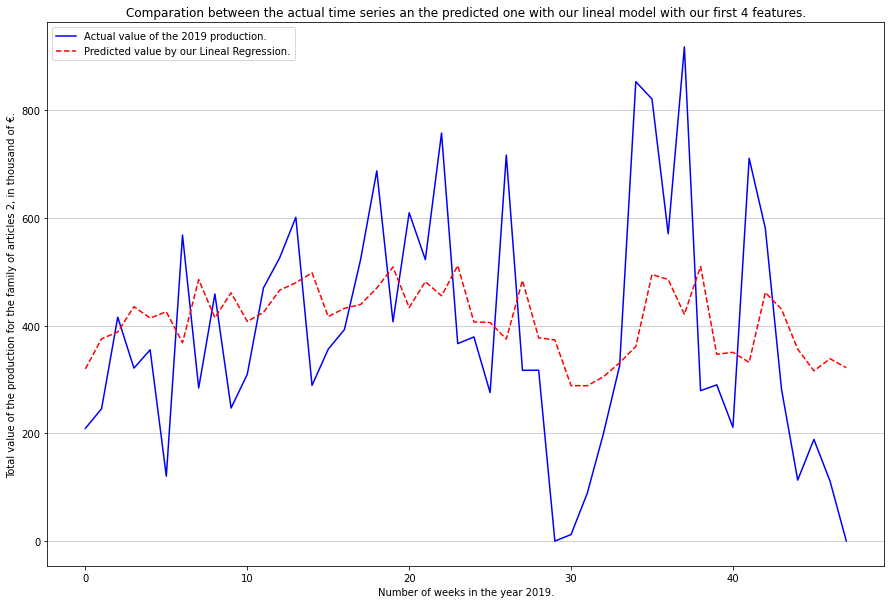

In [55]:
y_output = np.asarray(y_output)
y_Test_np = np.asarray(y_Test)
from pylab import rcParams
ax = plt.figure(figsize=(15,10)).add_subplot(111)
ax.plot(y_Test_np,'-b', label = 'Actual value of the 2019 production.')
ax.plot(y_output, '--r', label = 'Predicted value by our Lineal Regression.')
ax. legend(loc='upper left')
plt.title('Comparation between the actual time series an the predicted one with our lineal model with our first 4 features.')
plt.xlabel('Number of weeks in the year 2019.')
plt.ylabel('Total value of the production for the family of articles 2, in thousand of €.')

plt.grid(axis='y', alpha=0.75)

## 2. K nearest neighbours (KNN).<a name="id2"></a>

As we start with more complicated models, we start to deal with the problem of parameters optimization. In the case of KNN we need to select the best match for K (number of neighbours took into account). As far as we have a few rows in our dataser (191) we can do one in one out cross validation.

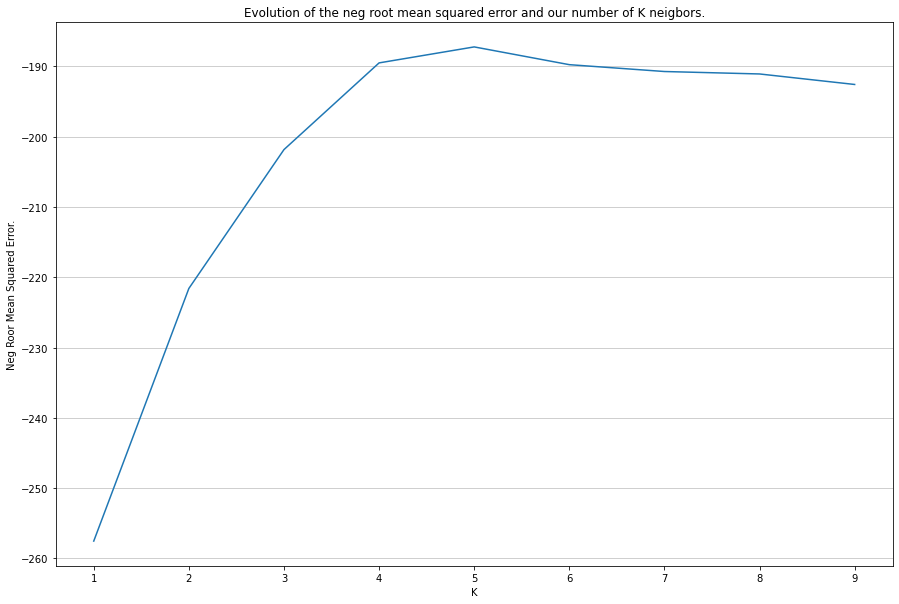

In [20]:


from sklearn.model_selection import cross_val_score
# Creating odd list K for KNN
neighbors = list(range(1,10))
# empty list that will hold cv scores
cv_scores = [ ]
#perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsRegressor(n_neighbors = K)
    scores = cross_val_score(knn,scaled_train,y_Train,cv = 191,scoring =
    "neg_root_mean_squared_error")
    cv_scores.append(scores.mean())
ax = plt.figure(figsize=(15,10)).add_subplot(111)
ax.plot(neighbors,cv_scores)
plt.title('Evolution of the neg root mean squared error and our number of K neigbors.')
plt.xlabel('K')
plt.ylabel('Neg Roor Mean Squared Error.')

plt.grid(axis='y', alpha=0.75)

It seems the best value for K is 5.

In [44]:
KNN_model = KNeighborsRegressor(n_neighbors=5)
model_3 = KNN_model.fit(scaled_train,y_Train)

In [45]:
y_output =  model_3.predict(scaled_test)

In [46]:
mean_squared_error(y_true= y_Test, y_pred=y_output, squared=False)

215.0877878856708

In [47]:
r2_score(y_true= y_Test, y_pred=y_output)

0.08026542838258166

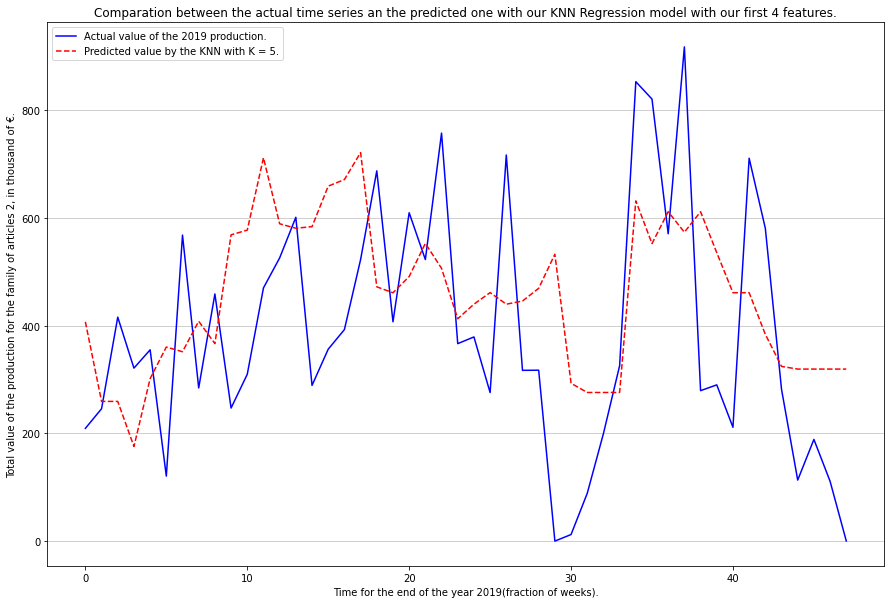

In [18]:
y_output = np.asarray(y_output)

from pylab import rcParams
ax = plt.figure(figsize=(15,10)).add_subplot(111)
ax.plot(y_Test_np,'-b', label = 'Actual value of the 2019 production.')
ax.plot(y_output, '--r', label = 'Predicted value by the KNN with K = 5.')
ax. legend(loc='upper left')
plt.title('Comparation between the actual time series an the predicted one with our KNN Regression model with our first 4 features.')
plt.xlabel('Time for the end of the year 2019(fraction of weeks).')
plt.ylabel('Total value of the production for the family of articles 2, in thousand of €.')

plt.grid(axis='y', alpha=0.75)

## 3. Random forest for Regression.<a name="id3"></a>

It is a very popular solution for complex problems like the one we are trying to solve. But as a more complex method it requires of more parameter optimization:

In [230]:

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [38]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [20,30, 40, 50,80, 90, 100, 110],
    'max_features': [2, 3,4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 50, 100, 200, 300, 1000]
}# Create a based model
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [39]:
best_choise = grid_search.fit(scaled_train, y_Train)

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 7776 out of 7776 

In [47]:
best_grid = best_choise.best_params_
best_grid

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 10}

In [8]:
model_4 = RandomForestRegressor(n_estimators=10,criterion='mse', max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, bootstrap=True)

In [9]:
model_4.fit(scaled_train, y_Train)

RandomForestRegressor(max_depth=110, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=10)

In [41]:
y_output = model_4.predict(scaled_test)

In [42]:
mean_squared_error(y_true= y_Test, y_pred=y_output, squared=False)

171.07017514305403

In [43]:
model_4.score(X = scaled_train, y = y_Train)

0.6345900554947144

In [44]:
model_4.decision_path(scaled_train)

(<191x506 sparse matrix of type '<class 'numpy.int64'>'
 	with 15206 stored elements in Compressed Sparse Row format>,
 array([  0,  49, 104, 153, 204, 255, 302, 351, 404, 451, 506], dtype=int32))

We see in the plot below that this solution match better that any other model so far:

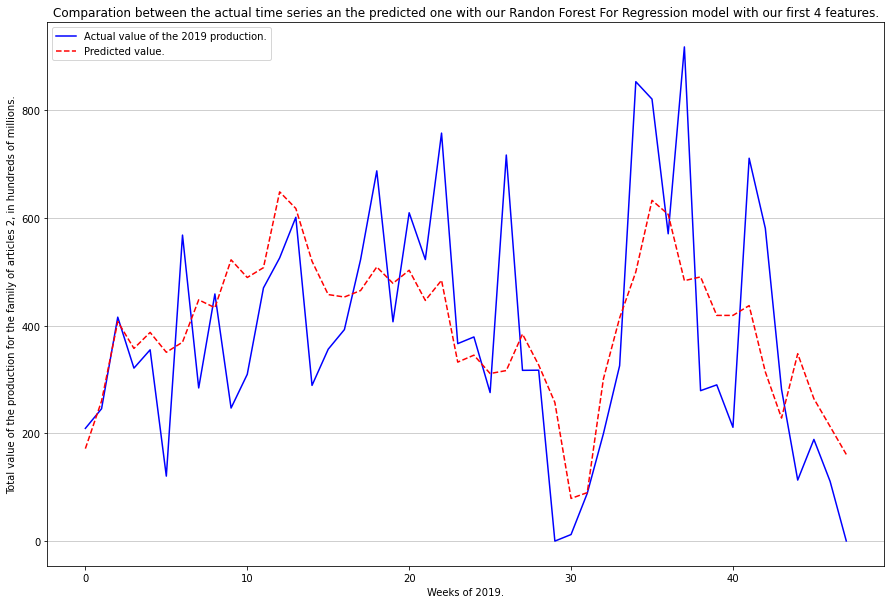

In [51]:
y_output = np.asarray(y_output)

from pylab import rcParams
ax = plt.figure(figsize=(15,10)).add_subplot(111)
ax.plot(y_Test_np,'-b', label = 'Actual value of the 2019 production.')
ax.plot(y_output, '--r', label = 'Predicted value.')
ax. legend(loc='upper left')
plt.title('Comparation between the actual time series an the predicted one with our Randon Forest For Regression model with our first 4 features.')
plt.xlabel('Weeks of 2019.')
plt.ylabel('Total value of the production for the family of articles 2, in hundreds of millions.')

plt.grid(axis='y', alpha=0.75)

In [46]:
y_output_m = pd.Series(y_output)
N = 4
y_output_m = y_output_m.groupby(y_output_m.index // N).sum()

In [48]:
y_Test_np = y_Test_np.reshape(48,)
y_Test_m = pd.Series(y_Test_np)
N = 4
y_Test_m = y_Test_m.groupby(y_Test_m.index // N).sum()

**Last key point to mention:**

We use as observations the aggregated production for each week for having more observations. Once we aggregate this to months we see our model imitates properly the behaviour of the time serie in its monthly version as well:

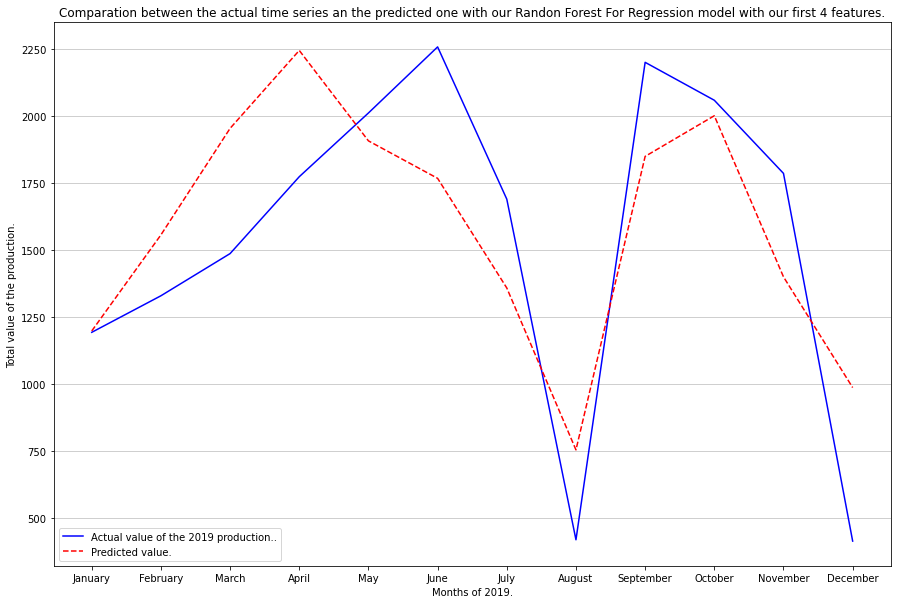

In [50]:
months = np.array(['January', 'February','March','April','May','June','July','August','September','October','November','December'])

## now we want to see all years at the same time just to compare between them:
ax = plt.figure(figsize=(15,10)).add_subplot(111)
ax.plot(months,y_Test_m,'-b', label = 'Actual value of the 2019 production..')
ax.plot(months,y_output_m,'--r', label = 'Predicted value.')

## we add legend and titles as well:
ax.legend(loc='lower left')
plt.title('Comparation between the actual time series an the predicted one with our Randon Forest For Regression model with our first 4 features.')
plt.xlabel('Months of 2019.')
plt.ylabel('Total value of the production.')
plt.grid(axis='y', alpha=0.75)

## 4. Last comments.<a name="id4"></a>

We see with not deep models like lineal regression or Decision Trees we have then improved result over our dummy predictors like last year, this show us that our time series problem is not that simple if we go to the weekly detail:

| Model | R${^2}$ | RMSE |
| --- | --- | --- |
| EMA last year (base line predictor) | --- | 211 thousand €|
| Lineal Model | 14% | 208 thousand €
| KNN | 8% | 215 thousand € |
| RFR | 63.5% | 171 thousand € |